In [1]:
import logging
import os
import qcodes as qc
import numpy as np
import xarray as xr
from scipy import interpolate
from qdsim import QcodesDataProvider, QuantumDotSim, dump_db
import matplotlib.pyplot as plt

### QCoDeS databases containing the datasets we will use

In [2]:
char_db_path = os.path.join(os.getcwd(), "data", "QuantumDots", "device_characterization.db")
tune_db_path = os.path.join(os.getcwd(), "data", "QuantumDots", "dot_tuning_sequences.db")

In [3]:
#qdsim.dump_db(chargestate_db_path)

### Create the simulated device

In [4]:
qdsim = QuantumDotSim()
qdsim

Inputs  : src, l_barrier, l_plunger, c_barrier, r_plunger, r_barrier
Outputs : drain

### Setup data providers to support pinchoff measurements of the device

In [5]:
#logging.getLogger().setLevel(logging.INFO)
logging.getLogger().setLevel(logging.WARN)

pinchoff_lb = QcodesDataProvider([qdsim.l_barrier], char_db_path, "GB_Newtown_Dev_3_2", 1203)
pinchoff_lp = QcodesDataProvider([qdsim.l_plunger], char_db_path, "GB_Newtown_Dev_3_2", 1204)
pinchoff_cb = QcodesDataProvider([qdsim.c_barrier], char_db_path, "GB_Newtown_Dev_3_2", 1205)
pinchoff_rp = QcodesDataProvider([qdsim.r_plunger], char_db_path, "GB_Newtown_Dev_3_2", 1206)
pinchoff_rb = QcodesDataProvider([qdsim.r_barrier], char_db_path, "GB_Newtown_Dev_3_2", 1207)

### Plot the 1D pinch-off traces 

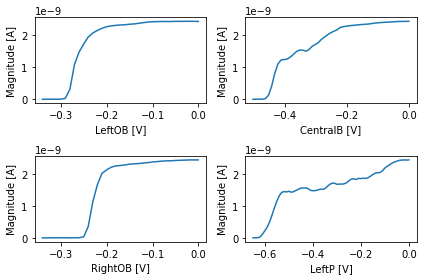

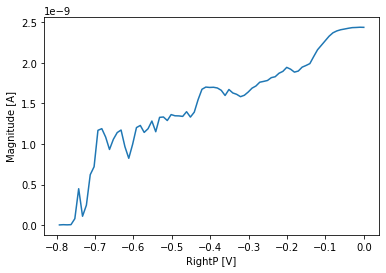

In [6]:
fig,axes = plt.subplots(ncols=2, nrows=2)
pinchoff_lb.raw_data["Magnitude"].plot(ax=axes[0,0])
pinchoff_cb.raw_data["Magnitude"].plot(ax=axes[0,1])
pinchoff_rb.raw_data["Magnitude"].plot(ax=axes[1,0])
pinchoff_lp.raw_data["Magnitude"].plot(ax=axes[1,1])
plt.tight_layout()
plt.draw()

plt.figure()
pinchoff_rp.raw_data["Magnitude"].plot()


### Simulate a pinchoff sweep of the right plunger

Set the data provider on the drain output pin.

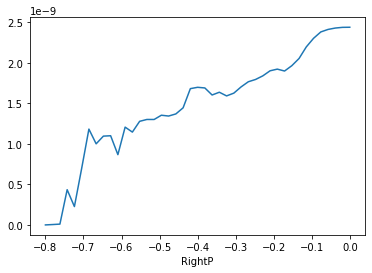

In [7]:
# Set the data provider for the output pin
qdsim.drain.set_data_provider(pinchoff_rp)

# Helper to set the input pin value, then return the value seen at the output pin
def set_input_then_read_output(x):
    qdsim.r_plunger.set_value(x)
    return qdsim.drain.value

size = 43
x = np.linspace(0.0, -0.8, size)
y = [set_input_then_read_output(x) for x in x]
data = xr.DataArray(y, dims={"RightP"}, coords={"RightP":x})
data.plot()

### Simulate a charge state diagram sweep of the left and right plungers

In [8]:
# create a data provider for charge-state data, using the left and Right Plunger gates as inputs
charge_state_data = QcodesDataProvider(input_providers = [qdsim.l_plunger, qdsim.r_plunger], db_path=tune_db_path, exp_name="GB_Newtown_Dev_1_1", run_id = 19)


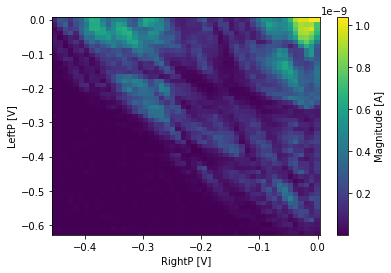

In [9]:
# Plot the raw data loaded by the data provider
xa = charge_state_data.raw_data
data = charge_state_data.raw_data["Magnitude"].plot()

In [10]:
# Set the drain's data provider to this data source
qdsim.drain.set_data_provider(charge_state_data)

# Helper to set the input pin values, then return the value seen at the output pin
def set_inputs_and_get_output(lp,rp):
    qdsim.l_plunger.set_value(lp)
    qdsim.r_plunger.set_value(rp)
    return qdsim.drain.value

count = 100
x = np.linspace(0.0, -0.6, count)
y = np.linspace(0.0, -0.4, count)
z = [[set_inputs_and_get_output(x1,y1) for x1 in x] for y1 in y]

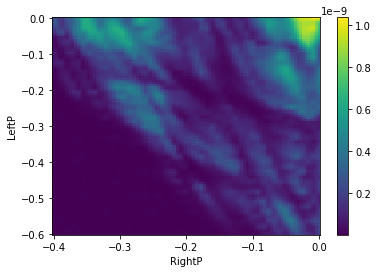

In [11]:
import xarray as xr
data = xr.DataArray(z, dims={"LeftP","RightP"}, coords={"LeftP":x, "RightP":y})
data.plot()